### Importing Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Loading Data and Preprocessing

In [2]:
 raw_data = yfinance.download(tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = '1994-01-07', end = '2021-04-13', 
                              interval = '1d', group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

### Removing Unwanted Columns

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']

### Setting Frequency and Filling Missing Values

In [6]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

### Creating Returns

In [7]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

### Normalizing

In [8]:
#Setting the benchmark
bench_1 = df_comp['ret_spx'].iloc[1]
bench_2 = df_comp['ret_ftse'].iloc[1]
bench_3 = df_comp['ret_dax'].iloc[1]
bench_4 = df_comp['ret_nikkei'].iloc[1]

In [9]:
#Normailzing the Returns
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(bench_1).mul(100)
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(bench_2).mul(100)
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(bench_3).mul(100)
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(bench_4).mul(100)

### Volatility of Returns

In [10]:
df_comp['s_spx'] = df_comp['ret_spx'] * df_comp['ret_spx']
df_comp['s_ftse'] = df_comp['ret_ftse'] * df_comp['ret_ftse']
df_comp['s_dax'] = df_comp['ret_dax'] * df_comp['ret_dax']
df_comp['s_nikkei'] = df_comp['ret_nikkei'] * df_comp['ret_nikkei']

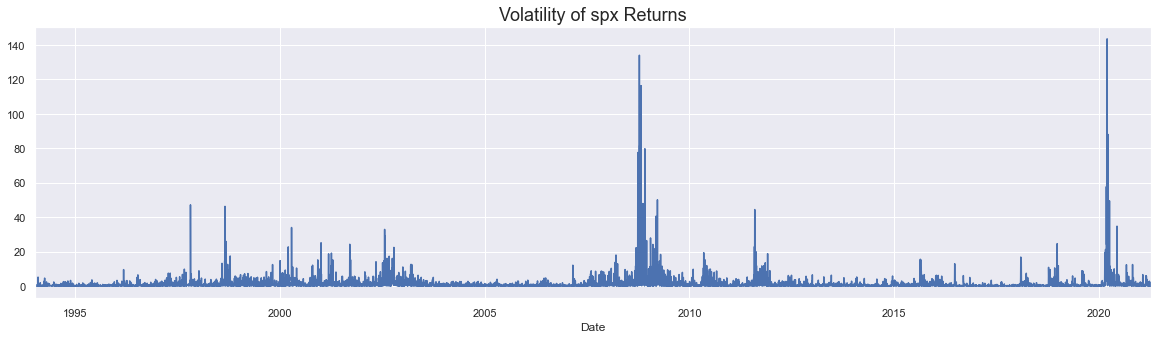

In [11]:
df_comp['s_spx'].plot(figsize = (20,5))
plt.title('Volatility of spx Returns', size = 18)
plt.show()

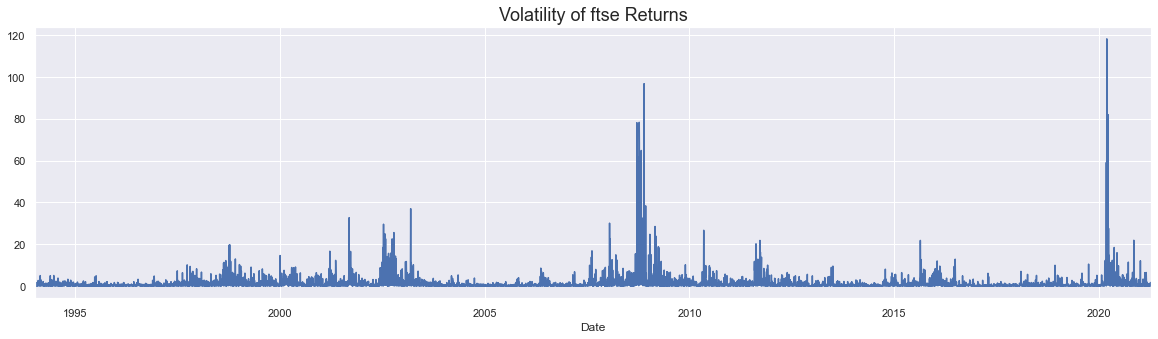

In [12]:
df_comp['s_ftse'].plot(figsize = (20,5))
plt.title('Volatility of ftse Returns', size = 18)
plt.show()

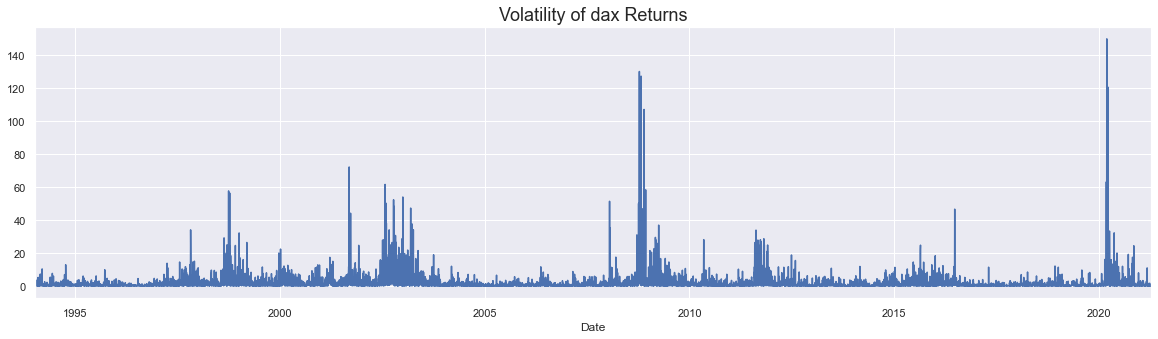

In [14]:
df_comp['s_dax'].plot(figsize = (20,5))
plt.title('Volatility of dax Returns', size = 18)
plt.show()

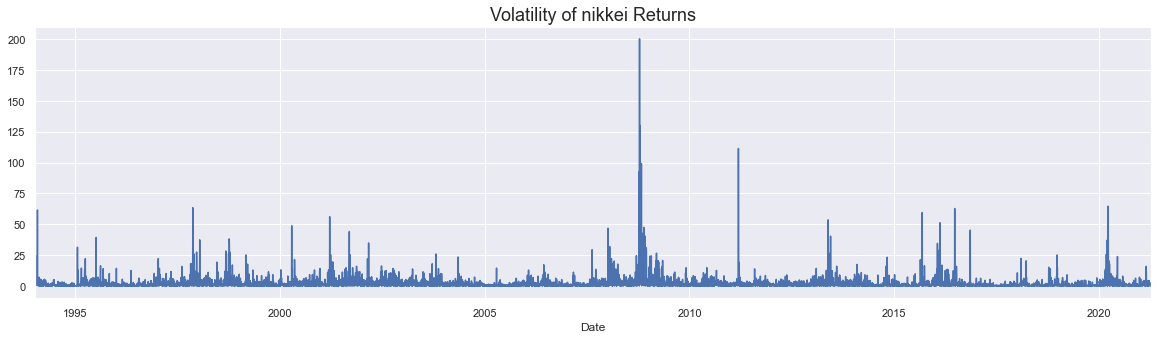

In [15]:
df_comp['s_nikkei'].plot(figsize = (20,5))
plt.title('Volatility of nikkei Returns', size = 18)
plt.show()

### Splitting the Data

In [16]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [17]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei,s_spx,s_ftse,s_dax,s_nikkei
,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-10-22,2052.510010,10491.969727,6376.299805,18435.869141,1.662757,0.439479,2.479661,-0.638182,-693.218927,-56.420511,1779.700299,-281.514605,2.764761,0.193142,6.148716,0.407277
2015-10-23,2075.149902,10794.540039,6444.100098,18825.300781,1.103034,1.063317,2.883828,2.112358,-459.865325,-136.509053,2069.778758,931.802098,1.216685,1.130643,8.316461,4.462058
2015-10-26,2071.179932,10801.339844,6417.000000,18947.119141,-0.191310,-0.420541,0.062993,0.647099,79.758947,53.989237,45.211294,285.447924,0.036600,0.176855,0.003968,0.418737
2015-10-27,2065.889893,10692.190430,6365.299805,18777.039062,-0.255412,-0.805675,-1.010517,-0.897657,106.483578,103.432913,-725.267837,-395.973687,0.065235,0.649113,1.021145,0.805787
2015-10-28,2090.350098,10831.959961,6437.799805,18903.019531,1.184003,1.138988,1.307211,0.670928,-493.622002,-146.223695,938.210878,295.959426,1.401864,1.297294,1.708802,0.450145


In [18]:
df_test.head()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei,s_spx,s_ftse,s_dax,s_nikkei
,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-10-29,2089.409912,10800.839844,6395.799805,18935.710938,-0.044977,-0.652397,-0.287299,0.172943,18.751505,83.754941,-206.200075,76.288396,0.002023,0.425622,0.082541,0.029909
2015-10-30,2079.360107,10850.139648,6361.100098,19083.099609,-0.480988,-0.542539,0.456444,0.778364,200.528247,69.651353,327.598808,343.351190,0.231349,0.294349,0.208341,0.605850
2015-11-02,2104.050049,10950.669922,6361.799805,18683.240234,1.187382,0.011000,0.926534,-2.095359,-495.030477,-1.412156,664.991626,-924.303147,1.409875,0.000121,0.858466,4.390528
2015-11-03,2109.790039,10951.150391,6383.600098,18683.240234,0.272807,0.342675,0.004388,0.000000,-113.735666,-43.992733,3.149047,0.000000,0.074424,0.117426,0.000019,0.000000
2015-11-04,2102.310059,10845.240234,6412.899902,18926.910156,-0.354537,0.458986,-0.967114,1.304217,147.809658,-58.924739,-694.116720,575.315126,0.125696,0.210668,0.935310,1.700981


### Fitting

In [19]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[['ret_spx','ret_dax','ret_nikkei']][1:],order = (1,0,1))
results_ret_armax = model_ret_armax.fit()
results_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5687
Model:                     ARMA(1, 1)   Log Likelihood               -5853.014
Method:                       css-mle   S.D. of innovations              0.677
Date:                Wed, 14 Apr 2021   AIC                          11720.028
Time:                        09:41:24   BIC                          11766.550
Sample:                    01-11-1994   HQIC                         11736.227
                         - 10-28-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0079      0.007     -1.092      0.275      -0.022       0.006
ret_spx            0.1108      0.010     11.217      0.000       0.091       0.130
ret_dax            0.5446      0.008     68.596      0.000       0.529       0.560
ret_nikkei         0.0763      0.006     11.967      0.000       0.064       0.089
ar.L1.ret_ftse     0.3861      0.109      3.529      0.000       0.172       0.600
ma.L1.ret_ftse    -0.5031      0.103     -4.904      0.000      -0.704      -0.302
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5902           +0.0000j            2.5902            0.0000
MA.1            1.9877           +0.0000j            1.9877            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
df_test.head()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei,s_spx,s_ftse,s_dax,s_nikkei
,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-10-29,2089.409912,10800.839844,6395.799805,18935.710938,-0.044977,-0.652397,-0.287299,0.172943,18.751505,83.754941,-206.200075,76.288396,0.002023,0.425622,0.082541,0.029909
2015-10-30,2079.360107,10850.139648,6361.100098,19083.099609,-0.480988,-0.542539,0.456444,0.778364,200.528247,69.651353,327.598808,343.351190,0.231349,0.294349,0.208341,0.605850
2015-11-02,2104.050049,10950.669922,6361.799805,18683.240234,1.187382,0.011000,0.926534,-2.095359,-495.030477,-1.412156,664.991626,-924.303147,1.409875,0.000121,0.858466,4.390528
2015-11-03,2109.790039,10951.150391,6383.600098,18683.240234,0.272807,0.342675,0.004388,0.000000,-113.735666,-43.992733,3.149047,0.000000,0.074424,0.117426,0.000019,0.000000
2015-11-04,2102.310059,10845.240234,6412.899902,18926.910156,-0.354537,0.458986,-0.967114,1.304217,147.809658,-58.924739,-694.116720,575.315126,0.125696,0.210668,0.935310,1.700981


In [47]:
start_date = '2015-10-29'
end_date = '2017-04-13'
df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

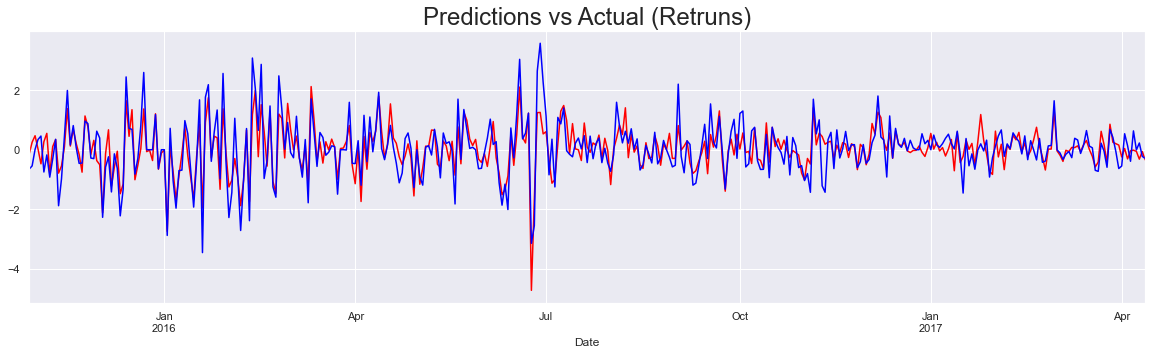

In [48]:
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Retruns)', size = 24)
plt.legend()
plt.show()

In [49]:
test_inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]

In [51]:
test_inputs[1]

(0, 1)

### Using Prices

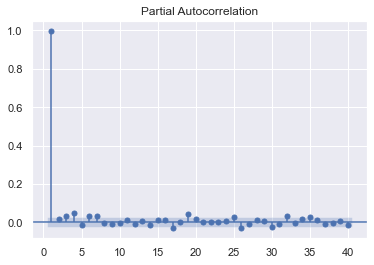

In [34]:
sgt.plot_pacf(df.ftse, zero = False, lags = 40)
plt.show()

In [40]:
model_ret_armax_1 = ARIMA(df.ftse[1:], exog = df[['spx','dax','nikkei']][1:],order = (1,1,1))
results_ret_armax_1 = model_ret_armax_1.fit()
results_ret_armax_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ftse   No. Observations:                 5686
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -31229.874
Method:                       css-mle   S.D. of innovations             58.761
Date:                Wed, 14 Apr 2021   AIC                          62473.748
Time:                        09:53:44   BIC                          62520.268
Sample:                    01-12-1994   HQIC                         62489.947
                         - 10-28-2015                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9570      3.381     -0.579      0.563      -8.583       4.669
spx              0.0074      0.006      1.327      0.185      -0.004       0.018
dax             -0.0013      0.001     -1.313      0.189      -0.003       0.001
nikkei        4.116e-05      0.000      0.256      0.798      -0.000       0.000
ar.L1.D.ftse     0.7912      0.083      9.530      0.000       0.628       0.954
ma.L1.D.ftse    -0.8310      0.076    -10.976      0.000      -0.979      -0.683
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2639           +0.0000j            1.2639            0.0000
MA.1            1.2034           +0.0000j            1.2034            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
df['res'] = results_ret_armax_1.resid

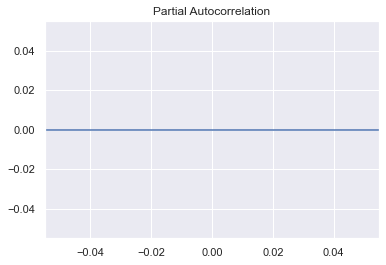

In [42]:
sgt.plot_pacf(df.res, zero = False, lags = 40)
plt.show()

In [36]:
start_date = '2015-10-29'
end_date = '2016-04-13'
df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[['spx','dax','nikkei']][start_date:end_date])

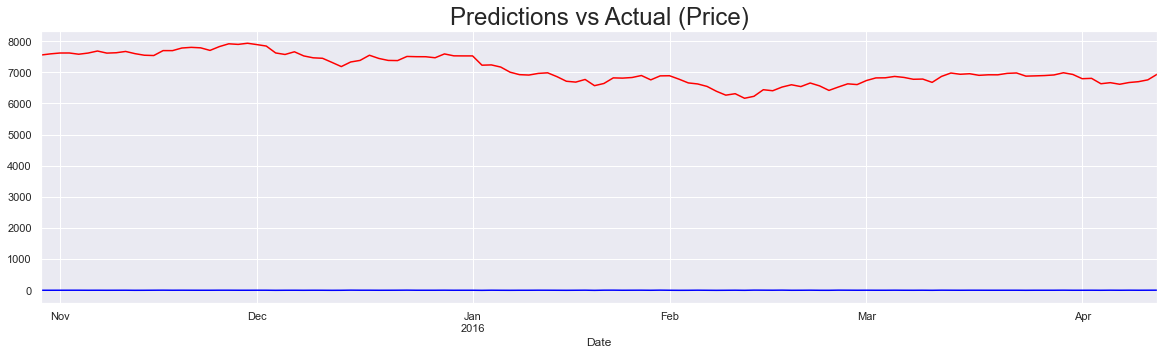

In [37]:
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Price)', size = 24)
plt.show()

### Volatility

In [40]:
df['s_spx'] = df['ret_spx'] * df['ret_spx']
df['s_ftse'] = df['ret_ftse'] * df['ret_ftse']
df['s_dax'] = df['ret_dax'] * df['ret_dax']
df['s_nikkei'] = df['ret_nikkei'] * df['ret_nikkei']

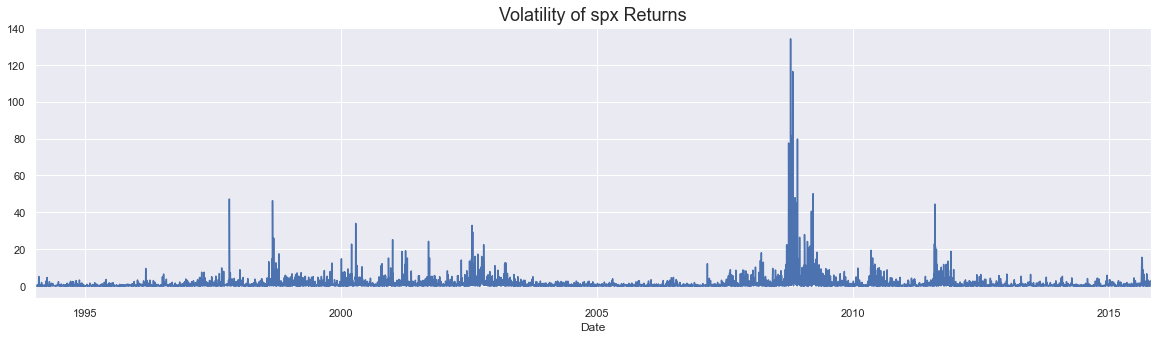

In [44]:
df['s_spx'].plot(figsize = (20,5))
plt.title('Volatility of spx Returns', size = 18)
plt.show()

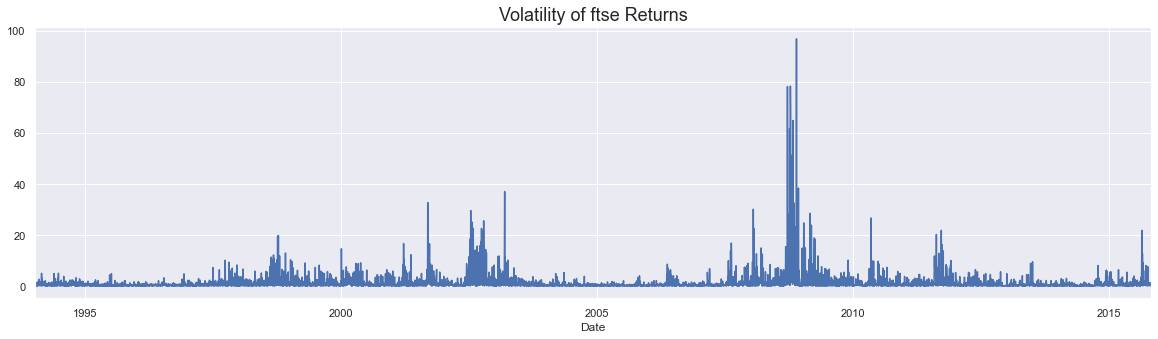

In [45]:
df['s_ftse'].plot(figsize = (20,5))
plt.title('Volatility of ftse Returns', size = 18)
plt.show()

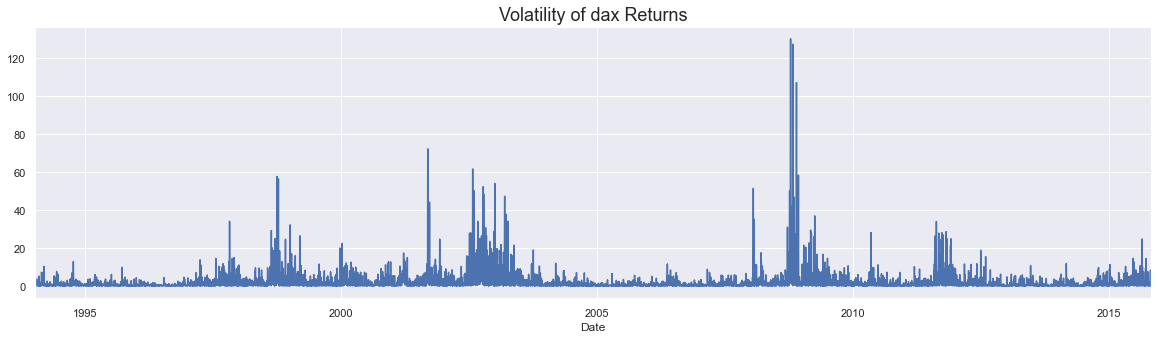

In [46]:
df['s_dax'].plot(figsize = (20,5))
plt.title('Volatility of dax Returns', size = 18)
plt.show()

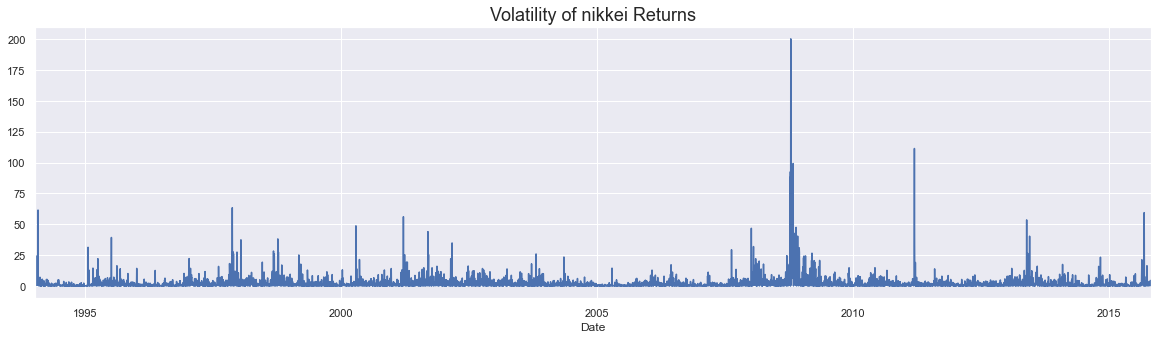

In [47]:
df['s_nikkei'].plot(figsize = (20,5))
plt.title('Volatility of nikkei Returns', size = 18)
plt.show()

### Garch

In [57]:
model_arch_spx = arch_model(df.ret_spx[1:], mean = 'constant', vol = 'ARCH', p = 2)
results_arch_spx = model_arch_spx.fit()
results_arch_spx.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 45405.292249910555
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2317240.0514723416
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8815.899473936128
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9163.462658067405
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8573.890172914536
Iteration:      6,   Func. Count:     42,   Neg. LLF: 8334.254339345618
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8334.213649676462
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8334.213605912006
Iteration:      9,   Func. Count:     56,   Neg. LLF: 8334.213605912095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8334.213605912006
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                ret_spx   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8334.21
Distribution:                  Normal   AIC:                           16676.4
Method:            Maximum Likelihood   BIC:                           16703.0
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:34:58   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0640  1.417e-02      4.516  6.314e-06 [3.621e-02,9.176e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6831  3.815e-02     17.908  1.029e-71 [  0.608,  0.758]
alpha[1]       0.1796  2.894e-02      6.206  5.433e-10 [  0.123,  0.236]
alpha[2]       0.3221  4.021e-02      8.008  1.163e-15 [  0.243,  0.401]
========================================================================

Covariance estimator: robust
"""

In [50]:
model_arch_ftse = arch_model(df.ret_ftse[1:], mean = 'constant', vol = 'ARCH', p = 1)
results_arch_ftse = model_arch_ftse.fit()
results_arch_ftse.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 34721.3192988916
Iteration:      2,   Func. Count:     13,   Neg. LLF: 13310.069777185025
Iteration:      3,   Func. Count:     20,   Neg. LLF: 8684.562077005205
Iteration:      4,   Func. Count:     26,   Neg. LLF: 8515.241057957268
Iteration:      5,   Func. Count:     30,   Neg. LLF: 8515.241047947642
Iteration:      6,   Func. Count:     33,   Neg. LLF: 8515.241047947682
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8515.241047947642
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8515.24
Distribution:                  Normal   AIC:                           17036.5
Method:            Maximum Likelihood   BIC:                           17056.4
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:28:09   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0351  1.471e-02      2.387  1.700e-02 [6.277e-03,6.394e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8690  3.836e-02     22.652 1.323e-113 [  0.794,  0.944]
alpha[1]       0.3689  4.741e-02      7.781  7.208e-15 [  0.276,  0.462]
========================================================================

Covariance estimator: robust
"""

In [51]:
model_arch_dax = arch_model(df.ret_dax[1:], mean = 'constant', vol = 'ARCH', p = 1)
results_arch_dax = model_arch_dax.fit()
results_arch_dax.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 38175.49246213118
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5174373.390543192
Iteration:      3,   Func. Count:     19,   Neg. LLF: 10518.456990753859
Iteration:      4,   Func. Count:     25,   Neg. LLF: 10037.5769625226
Iteration:      5,   Func. Count:     29,   Neg. LLF: 10037.574368695243
Iteration:      6,   Func. Count:     33,   Neg. LLF: 10037.574346275314
Iteration:      7,   Func. Count:     36,   Neg. LLF: 10037.574346275649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10037.574346275314
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                ret_dax   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10037.6
Distribution:                  Normal   AIC:                           20081.1
Method:            Maximum Likelihood   BIC:                           20101.1
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:29:28   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0750  1.843e-02      4.072  4.669e-05 [3.892e-02,  0.111]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.5794  6.470e-02     24.411 1.312e-131 [  1.453,  1.706]
alpha[1]       0.2840  3.564e-02      7.969  1.593e-15 [  0.214,  0.354]
========================================================================

Covariance estimator: robust
"""

In [52]:
model_arch_nikkei = arch_model(df.ret_nikkei[1:], mean = 'constant', vol = 'ARCH', p = 1)
results_arch_nikkei = model_arch_nikkei.fit()
results_arch_nikkei.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2631422883042.8257
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3144010817.7835455
Iteration:      3,   Func. Count:     19,   Neg. LLF: 10256.22960377712
Iteration:      4,   Func. Count:     25,   Neg. LLF: 10137.728982549137
Iteration:      5,   Func. Count:     30,   Neg. LLF: 10137.594361712163
Iteration:      6,   Func. Count:     33,   Neg. LLF: 10137.594361712188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10137.594361712163
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:             ret_nikkei   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10137.6
Distribution:                  Normal   AIC:                           20281.2
Method:            Maximum Likelihood   BIC:                           20301.1
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:30:07   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0230  1.901e-02      1.208      0.227 [-1.430e-02,6.023e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.8231  8.372e-02     21.776 3.914e-105   [  1.659,  1.987]
alpha[1]       0.1465  2.749e-02      5.329  9.871e-08 [9.263e-02,  0.200]
==========================================================================

Covariance estimator: robust
"""

### Garch

In [53]:
model_garch_spx = arch_model(df.ret_ftse[1:], mean = 'constant', vol = 'GARCH', p = 1, q = 1)
results_garch_spx = model_garch_spx.fit()
results_garch_spx.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7036401840.24571
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1162219867.3023684
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7806.9427181180545
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7827.295243948745
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7764.103116948609
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7927.413349991717
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8450.144552179905
Iteration:      8,   Func. Count:     55,   Neg. LLF: 7759.462137494467
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7759.349654586672
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7759.348563278586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7759.34855738638
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7759.348557389811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7759.34855738638
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7759.35
Distribution:                  Normal   AIC:                           15526.7
Method:            Maximum Likelihood   BIC:                           15553.3
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:31:34   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0427  1.101e-02      3.877  1.057e-04 [2.111e-02,6.428e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0121  3.170e-03      3.809  1.394e-04 [5.863e-03,1.829e-02]
alpha[1]       0.0875  1.148e-02      7.624  2.468e-14   [6.501e-02,  0.110]
beta[1]        0.9035  1.257e-02     71.865      0.000     [  0.879,  0.928]
============================================================================

Covariance estimator: robust
"""

In [54]:
model_garch_ftse = arch_model(df.ret_ftse[1:], mean = 'constant', vol = 'GARCH', p = 1, q = 1)
results_garch_ftse = model_garch_ftse.fit()
results_garch_ftse.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7036401840.24571
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1162219867.3023684
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7806.9427181180545
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7827.295243948745
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7764.103116948609
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7927.413349991717
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8450.144552179905
Iteration:      8,   Func. Count:     55,   Neg. LLF: 7759.462137494467
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7759.349654586672
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7759.348563278586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7759.34855738638
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7759.348557389811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7759.34855738638
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7759.35
Distribution:                  Normal   AIC:                           15526.7
Method:            Maximum Likelihood   BIC:                           15553.3
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:33:32   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0427  1.101e-02      3.877  1.057e-04 [2.111e-02,6.428e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0121  3.170e-03      3.809  1.394e-04 [5.863e-03,1.829e-02]
alpha[1]       0.0875  1.148e-02      7.624  2.468e-14   [6.501e-02,  0.110]
beta[1]        0.9035  1.257e-02     71.865      0.000     [  0.879,  0.928]
============================================================================

Covariance estimator: robust
"""

In [55]:
model_garch_nikkei = arch_model(df.ret_ftse[1:], mean = 'constant', vol = 'GARCH', p = 1, q = 1)
results_garch_nikkei = model_garch_nikkei.fit()
results_garch_nikkei.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7036401840.24571
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1162219867.3023684
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7806.9427181180545
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7827.295243948745
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7764.103116948609
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7927.413349991717
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8450.144552179905
Iteration:      8,   Func. Count:     55,   Neg. LLF: 7759.462137494467
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7759.349654586672
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7759.348563278586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7759.34855738638
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7759.348557389811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7759.34855738638
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7759.35
Distribution:                  Normal   AIC:                           15526.7
Method:            Maximum Likelihood   BIC:                           15553.3
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:34:07   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0427  1.101e-02      3.877  1.057e-04 [2.111e-02,6.428e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0121  3.170e-03      3.809  1.394e-04 [5.863e-03,1.829e-02]
alpha[1]       0.0875  1.148e-02      7.624  2.468e-14   [6.501e-02,  0.110]
beta[1]        0.9035  1.257e-02     71.865      0.000     [  0.879,  0.928]
============================================================================

Covariance estimator: robust
"""

In [56]:
model_garch_dax = arch_model(df.ret_ftse[1:], mean = 'constant', vol = 'GARCH', p = 1, q = 1)
results_garch_dax = model_garch_dax.fit()
results_garch_dax.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7036401840.24571
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1162219867.3023684
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7806.9427181180545
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7827.295243948745
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7764.103116948609
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7927.413349991717
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8450.144552179905
Iteration:      8,   Func. Count:     55,   Neg. LLF: 7759.462137494467
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7759.349654586672
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7759.348563278586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 7759.34855738638
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7759.348557389811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7759.34855738638
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_ftse   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7759.35
Distribution:                  Normal   AIC:                           15526.7
Method:            Maximum Likelihood   BIC:                           15553.3
                                        No. Observations:                 5687
Date:                Wed, Apr 14 2021   Df Residuals:                     5686
Time:                        09:34:40   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0427  1.101e-02      3.877  1.057e-04 [2.111e-02,6.428e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0121  3.170e-03      3.809  1.394e-04 [5.863e-03,1.829e-02]
alpha[1]       0.0875  1.148e-02      7.624  2.468e-14   [6.501e-02,  0.110]
beta[1]        0.9035  1.257e-02     71.865      0.000     [  0.879,  0.928]
============================================================================

Covariance estimator: robust
"""